In [36]:
# Import all packages required for this project. 
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
import sys
import pandas
from sklearn.multiclass import OneVsRestClassifier
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [37]:
# Read the files and name them accordingly
iplmatches = pd.read_csv('matches.csv')
ipldelivery = pd.read_csv('deliveries.csv')

In [38]:
#Ensure that the file is being read correctly
ipldelivery.head(5)
iplmatches.head(3)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN


In [39]:
## BATSMEN DATA GROUPED BY MATCH
# Here the data is grouped to provide deeper depth of statistics and later for the team classificaiton

batsman_grp = ipldelivery.groupby(["match_id", "inning", "batting_team", "batsman"])
batsmen = batsman_grp["batsman_runs"].sum().reset_index()

# Ignore the wide balls.
balls_faced = ipldelivery[ipldelivery["wide_runs"] == 0]
balls_faced = balls_faced.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count().reset_index()
balls_faced.columns = ["match_id", "inning", "batsman", "balls_faced"]
batsmen = batsmen.merge(balls_faced, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")

fours = ipldelivery[ ipldelivery["batsman_runs"] == 4]
sixes = ipldelivery[ ipldelivery["batsman_runs"] == 6]

fours_per_batsman = fours.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count().reset_index()
sixes_per_batsman = sixes.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count().reset_index()

fours_per_batsman.columns = ["match_id", "inning", "batsman", "4s"]
sixes_per_batsman.columns = ["match_id", "inning", "batsman", "6s"]

batsmen = batsmen.merge(fours_per_batsman, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")
batsmen = batsmen.merge(sixes_per_batsman, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")
batsmen['SR'] = np.round(batsmen['batsman_runs'] / batsmen['balls_faced'] * 100, 2)

for col in ["batsman_runs", "4s", "6s", "balls_faced", "SR"]:
    batsmen[col] = batsmen[col].fillna(0)

dismissals = ipldelivery[ pd.notnull(ipldelivery["player_dismissed"])]
dismissals = dismissals[["match_id", "inning", "player_dismissed", "dismissal_kind", "fielder"]]
dismissals.rename(columns={"player_dismissed": "batsman"}, inplace=True)
batsmen = batsmen.merge(dismissals, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")

batsmen = iplmatches[['id','season']].merge(batsmen, left_on = 'id', right_on = 'match_id', how = 'left').drop('id', axis = 1)
batsmen.head(10)

,season,match_id,inning,batting_team,batsman,batsman_runs,balls_faced,4s,6s,SR,dismissal_kind,fielder
0,2017,1,1,Sunrisers Hyderabad,BCJ Cutting,16,6.0,0.0,2.0,266.67,NaN,NaN
1,2017,1,1,Sunrisers Hyderabad,DA Warner,14,8.0,2.0,1.0,175.00,caught,Mandeep Singh
2,2017,1,1,Sunrisers Hyderabad,DJ Hooda,16,12.0,0.0,1.0,133.33,NaN,NaN
3,2017,1,1,Sunrisers Hyderabad,MC Henriques,52,37.0,3.0,2.0,140.54,caught,Sachin Baby
4,2017,1,1,Sunrisers Hyderabad,S Dhawan,40,31.0,5.0,0.0,129.03,caught,Sachin Baby
5,2017,1,1,Sunrisers Hyderabad,Yuvraj Singh,62,27.0,7.0,3.0,229.63,bowled,NaN
6,2017,1,2,Royal Challengers Bangalore,A Choudhary,6,2.0,0.0,1.0,300.00,NaN,NaN
7,2017,1,2,Royal Challengers Bangalore,CH Gayle,32,21.0,2.0,3.0,152.38,caught,DA Warner
8,2017,1,2,Royal Challengers Bangalore,KM Jadhav,31,16.0,4.0,1.0,193.75,run out,BCJ Cutting
9,2017,1,2,Royal Challengers Bangalore,Mandeep Singh,24,16.0,5.0,0.0,150.00,bowled,NaN


In [40]:
## Bowlers grouped by sets of data
# Data is grouped for bowlers to provide greater depth of information. Very important for the regression analysis.

bowler_grp = ipldelivery.groupby(["match_id", "inning", "bowling_team", "bowler", "over"])
bowlers = bowler_grp["total_runs", "wide_runs", "bye_runs", "legbye_runs", "noball_runs"].sum().reset_index()

bowlers["runs"] = bowlers["total_runs"] - (bowlers["bye_runs"] + bowlers["legbye_runs"])
bowlers["extras"] = bowlers["wide_runs"] + bowlers["noball_runs"]

del( bowlers["bye_runs"])
del( bowlers["legbye_runs"])
del( bowlers["total_runs"])

dismissal_kinds_for_bowler = ["bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"]
dismissals = ipldelivery[ipldelivery["dismissal_kind"].isin(dismissal_kinds_for_bowler)]
dismissals = dismissals.groupby(["match_id", "inning", "bowling_team", "bowler", "over"])["dismissal_kind"].count().reset_index()
dismissals.rename(columns={"dismissal_kind": "wickets"}, inplace=True)

bowlers = bowlers.merge(dismissals, left_on=["match_id", "inning", "bowling_team", "bowler", "over"], 
                        right_on=["match_id", "inning", "bowling_team", "bowler", "over"], how="left")
bowlers["wickets"] = bowlers["wickets"].fillna(0)

bowlers_over = bowlers.groupby(['match_id', 'inning', 'bowling_team', 'bowler'])['over'].count().reset_index()
bowlers = bowlers.groupby(['match_id', 'inning', 'bowling_team', 'bowler']).sum().reset_index().drop('over', 1)
bowlers = bowlers_over.merge(bowlers, on=["match_id", "inning", "bowling_team", "bowler"], how = 'left')
bowlers['Econ'] = np.round(bowlers['runs'] / bowlers['over'] , 2)
bowlers = iplmatches[['id','season']].merge(bowlers, left_on = 'id', right_on = 'match_id', how = 'left').drop('id', axis = 1)

bowlers.head(10)

,season,match_id,inning,bowling_team,bowler,over,wide_runs,noball_runs,runs,extras,wickets,Econ
0,2017,1,1,Royal Challengers Bangalore,A Choudhary,4,3,1,55,4,1.0,13.75
1,2017,1,1,Royal Challengers Bangalore,S Aravind,3,0,0,36,0,0.0,12.00
2,2017,1,1,Royal Challengers Bangalore,SR Watson,3,0,0,41,0,0.0,13.67
3,2017,1,1,Royal Challengers Bangalore,STR Binny,1,0,0,10,0,1.0,10.00
4,2017,1,1,Royal Challengers Bangalore,TM Head,1,0,0,11,0,0.0,11.00
5,2017,1,1,Royal Challengers Bangalore,TS Mills,4,2,0,31,2,1.0,7.75
6,2017,1,1,Royal Challengers Bangalore,YS Chahal,4,0,0,22,0,1.0,5.50
7,2017,1,2,Sunrisers Hyderabad,A Nehra,4,1,0,42,1,2.0,10.50
8,2017,1,2,Sunrisers Hyderabad,B Kumar,4,1,0,27,1,2.0,6.75
9,2017,1,2,Sunrisers Hyderabad,BCJ Cutting,4,2,0,35,2,0.0,8.75


In [41]:
# Ensure the data is grouped carefully. Name them accordingly as above. 
iplmatches.describe()

,id,season,dl_applied,win_by_runs,win_by_wickets,umpire3
count,636.000000,636.000000,636.000000,636.000000,636.000000,0.0
mean,318.500000,2012.490566,0.025157,13.682390,3.372642,NaN
std,183.741666,2.773026,0.156726,23.908877,3.420338,NaN
min,1.000000,2008.000000,0.000000,0.000000,0.000000,NaN
25%,159.750000,2010.000000,0.000000,0.000000,0.000000,NaN
50%,318.500000,2012.000000,0.000000,0.000000,4.000000,NaN
75%,477.250000,2015.000000,0.000000,20.000000,7.000000,NaN
max,636.000000,2017.000000,1.000000,146.000000,10.000000,NaN


Below is some Data Visualization techniques and basic Statistical Techniques

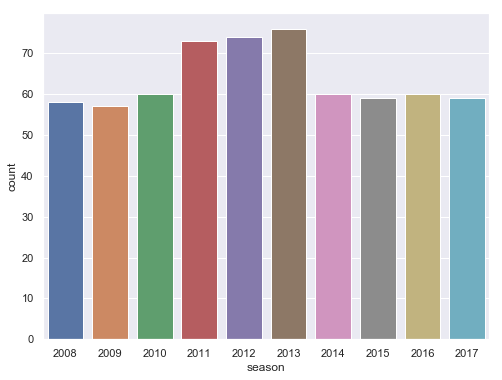

In [42]:
sns.countplot(x = 'season', data = iplmatches)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

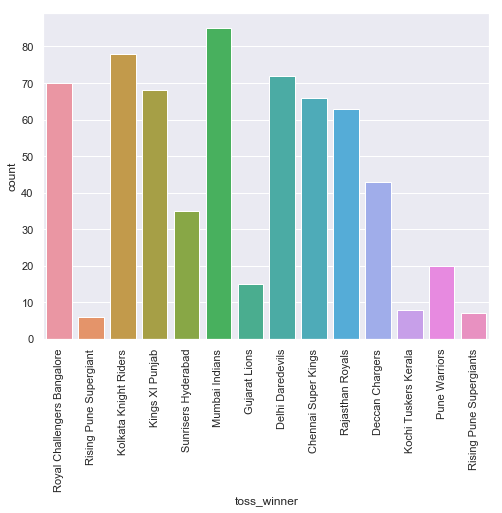

In [43]:
sns.countplot( x = 'toss_winner', data = iplmatches)
plt.xticks(rotation='vertical')

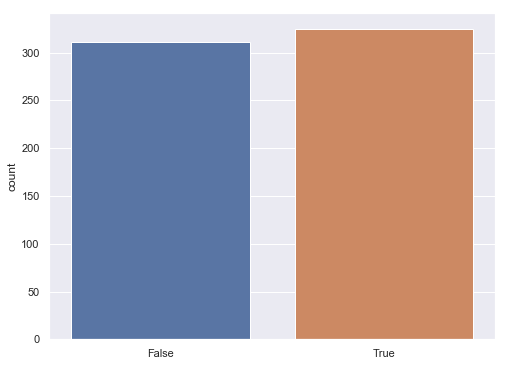

In [44]:
winneroft = iplmatches['toss_winner'] == iplmatches['winner']
winneroft.groupby(winneroft).size()
sns.countplot(winneroft)


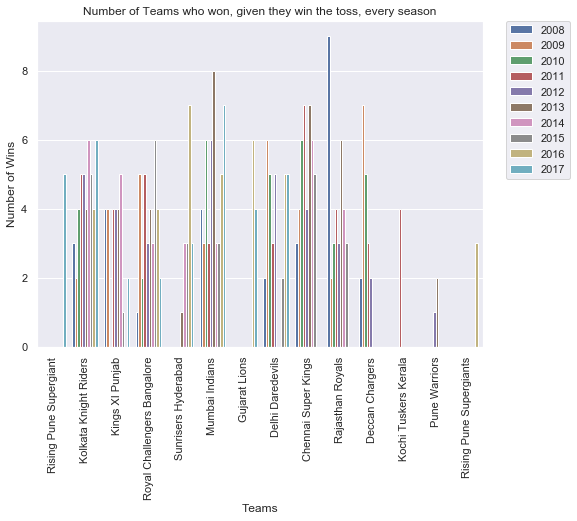

In [45]:
winneroftoss = iplmatches[(iplmatches['toss_winner']) == (iplmatches['winner'])]

wot = sns.countplot( x = 'winner', hue='season', data=winneroftoss)
sns.set(rc={'figure.figsize':(8,6)})
plt.xticks(rotation = 'vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Teams")
plt.ylabel("Number of Wins")
plt.title("Number of Teams who won, given they win the toss, every season")
plt.show(wot)

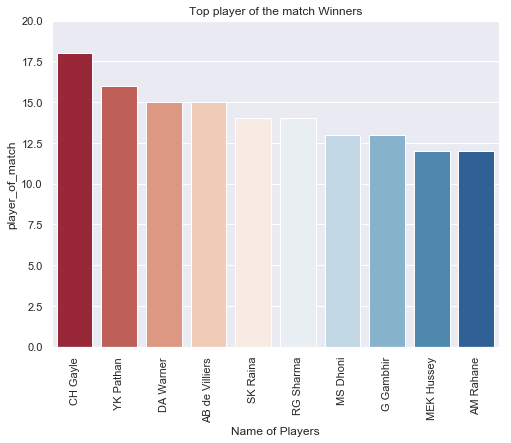

In [46]:
top_players = iplmatches.player_of_match.value_counts()[:10]
#sns.barplot(x="day", y="total_bill", data=tips)
fig, ax = plt.subplots()
ax.set_ylim([0,20])
ax.set_ylabel("Number of Awards")
ax.set_xlabel("Name of Players")
ax.set_title("Top player of the match Winners")
#top_players.plot.bar()
sns.barplot(x = top_players.index, y = top_players, orient='v', palette="RdBu");
plt.xticks(rotation = 'vertical')
plt.show()

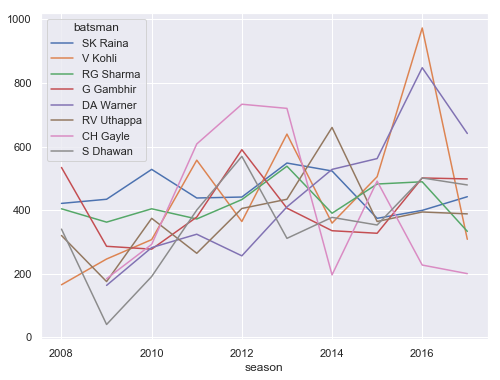

In [47]:
## Question regarding top bastsmen and top bowlers in history of IPL.

batsman_runsperseason = batsmen.groupby(['season', 'batting_team', 'batsman'])['batsman_runs'].sum().reset_index()
batsman_runsperseason = batsman_runsperseason.groupby(['season', 'batsman'])['batsman_runs'].sum().unstack().T
batsman_runsperseason['Total'] = batsman_runsperseason.sum(axis=1) #add total column to find batsman with the highest runs
batsman_runsperseason = batsman_runsperseason.sort_values(by = 'Total', ascending = False).drop('Total', 1)
ax.set_ylabel('Number of Runs')
ax = batsman_runsperseason[:8].T.plot()

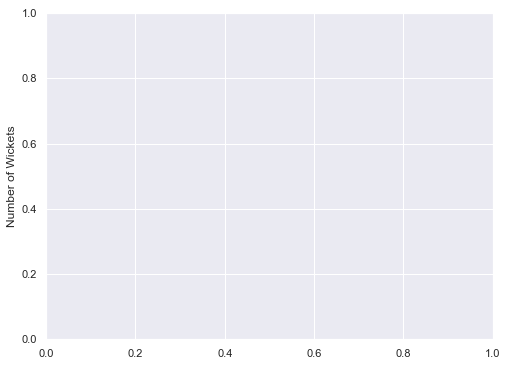

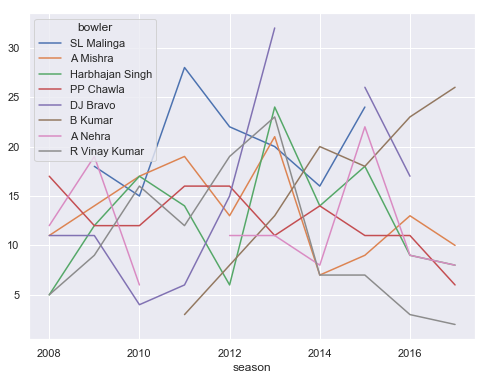

In [48]:
bowler_wicketsperseason = bowlers.groupby(['season', 'bowling_team', 'bowler'])['wickets'].sum().reset_index()
bowler_wicketsperseason = bowler_wicketsperseason.groupby(['season', 'bowler'])['wickets'].sum().unstack().T
bowler_wicketsperseason ['Total'] = bowler_wicketsperseason .sum(axis=1) #add total column to find bowler with the highest number of wickets
bowler_wicketsperseason  = bowler_wicketsperseason .sort_values(by = 'Total', ascending = False).drop('Total', 1)
plt.ylabel('Number of Wickets')
ax = bowler_wicketsperseason [:8].T.plot()

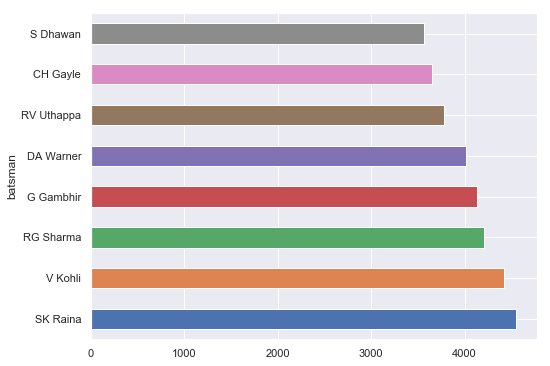

In [49]:
runs_scored=batsmen.groupby(['batsman'])['batsman_runs'].sum()
runs_scored=runs_scored.sort_values(ascending=False)
top10runs = runs_scored.head(8)
top10runs.plot('barh')

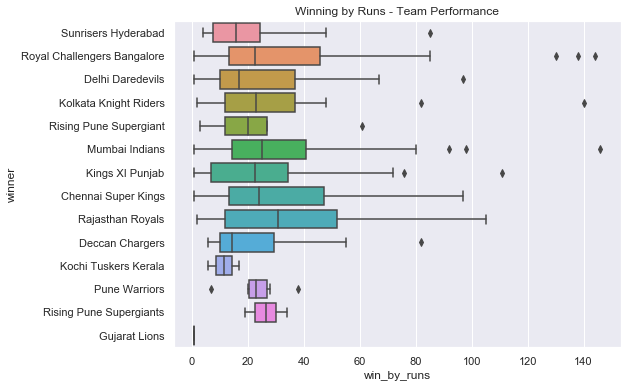

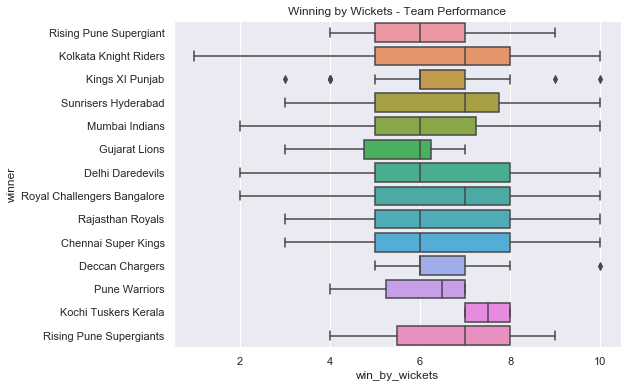

In [50]:
## Barplot of Runs

#sns.barplot(x="day", y="total_bill", data=tips)
fig, ax = plt.subplots()
#fig.figsize = [16,10]
#ax.set_ylim([0,20])
ax.set_xlabel("Runs")
ax.set_title("Winning by Runs - Team Performance")
#top_players.plot.bar()
sns.boxplot(y = 'winner', x = 'win_by_runs', data=iplmatches[iplmatches['win_by_runs']>0], orient = 'h'); #palette="Blues");
plt.show()

## Barplot of Wickets Win

#sns.barplot(x="day", y="total_bill", data=tips)
fig, ax = plt.subplots()
#fig.figsize = [16,10]
#ax.set_ylim([0,20])
ax.set_title("Winning by Wickets - Team Performance")
#top_players.plot.bar()
sns.boxplot(y = 'winner', x = 'win_by_wickets', data=iplmatches[iplmatches['win_by_wickets']>0], orient = 'h'); #palette="Blues");
plt.show()


=====================================================================================================

Now we are going to do some Classification.
Please note that I will do very little explaining and more so for the user to explore and figure out the statistical methods used under it. 


In [51]:
# Import the new Dataset.
# Now for this dataset, I removed some features that I felt were unnecessary from the original IPL
# Dataset. However, you can use that or use the one below with a screenshot of the headings.
matches = pandas.read_csv('matches1234.csv')

In [52]:
matches.head(3)

,season,city,team1,team2,toss_winner,toss_decision,winner,win_by_runs,win_by_wickets,venue,umpire1
0,2017,Hyderabad,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,Sunrisers Hyderabad,35,0,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar
1,2017,Pune,Mumbai Indians,Rising Pune Supergiants,Rising Pune Supergiants,field,Rising Pune Supergiants,0,7,Maharashtra Cricket Association Stadium,A Nand Kishore
2,2017,Rajkot,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,Kolkata Knight Riders,0,10,Saurashtra Cricket Association Stadium,Nitin Menon


In [72]:
# Make a copy of the dataset that you imported or used before
copy_data = matches.copy()


In [73]:
# As to ensure data integrity, make sure there are no missing values. In some cases you can take the mean to ensure fairness. In this case
# the values missing are types and so I filled them with these names. You could do otherwise if you wish
copy_data['city'].fillna('Dubai',inplace=True)
copy_data['umpire1'].fillna('Aleem Dar',inplace=True)

In [74]:
# Firstly, we should have a look whether the data is completed or not.
# Because the missing value will have an adverse impact on the building of regression model.

null_values_col = copy_data.isnull().sum()
null_values_col = null_values_col[null_values_col != 0].sort_values(ascending = False).reset_index()
null_values_col.columns = ["variable", "number of missing"]
null_values_col.head()

,variable,number of missing


In [75]:
print(copy_data.columns)

Index(['season', 'city', 'team1', 'team2', 'toss_winner', 'toss_decision',
       'winner', 'win_by_runs', 'win_by_wickets', 'venue', 'umpire1'],
      dtype='object')


In [76]:
#Create now a dataframe copy of the data and all its rows and named columns.
df = DataFrame(copy_data,columns=['team1', 'team2', 'toss_decision','toss_winner','city', 'venue', 'season', 'win_by_runs', 'win_by_wickets', 'umpire1', 'winner'])

In [77]:
# Now what we have done is replace the name values with numbers. Regression can only be run with 
# numbers and not anything else. 
df['winner'].fillna('Draw', inplace=True)
df.replace(['Mumbai Indians','Kolkata Knight Riders','Royal Challengers Bangalore','Deccan Chargers','Chennai Super Kings',
                 'Rajasthan Royals','Delhi Daredevils','Gujarat Lions','Kings XI Punjab',
                 'Sunrisers Hyderabad','Rising Pune Supergiants','Kochi Tuskers Kerala','Pune Warriors']
                ,['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW'],inplace=True)

encode = {'team1': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13},
          'team2': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13},
          'toss_winner': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13},
          'winner': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13,'Draw':14}}
df.replace(encode, inplace=True)

In [78]:
dicVal = encode['winner']
print(dicVal['MI']) #key value
print(list(dicVal.keys())[list(dicVal.values()).index(1)])

1
MI


In [79]:
# If any of the types are objects, then this needs to be changed to integers
df.dtypes

team1              int64
team2              int64
toss_decision     object
toss_winner        int64
city              object
venue             object
season             int64
win_by_runs        int64
win_by_wickets     int64
umpire1           object
winner             int64
dtype: object

In [80]:
# This allows any columns to be changed with the corresponding values.
from sklearn.preprocessing import LabelEncoder
var_mod = ['toss_decision', 'city', 'venue', 'umpire1']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes

team1             int64
team2             int64
toss_decision     int32
toss_winner       int64
city              int32
venue             int32
season            int64
win_by_runs       int64
win_by_wickets    int64
umpire1           int32
winner            int64
dtype: object

In [81]:
#Compare the data at the beginning to now, ensuring no string value remains.
df.head(150)

,team1,team2,toss_decision,toss_winner,city,venue,season,win_by_runs,win_by_wickets,umpire1,winner
0,10,3,1,3,14,23,2017,35,0,5,10
1,1,11,1,11,25,16,2017,0,7,1,11
2,8,2,1,2,27,25,2017,0,10,27,2
3,11,9,1,9,15,11,2017,0,6,2,9
4,3,7,0,3,2,14,2017,15,0,6,3
5,8,10,1,10,14,23,2017,0,9,0,10
6,2,1,1,1,22,34,2017,0,4,27,1
7,3,9,0,3,15,11,2017,0,8,2,9
8,7,11,1,11,25,16,2017,97,0,5,7
9,10,1,1,1,22,34,2017,0,4,27,1


In [123]:
# Now we are going to split the training and test models in a typical 60:20:20 set.
x = df[['team1', 'team2', 'toss_decision','toss_winner','city', 'venue', 'season', 'win_by_runs', 'win_by_wickets', 'umpire1']]
y = df[['winner']]

x_model, x_test, y_model, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_model, y_model, test_size=0.2, random_state=1)

In [124]:
# Model Tuning

# 5-fold cross validation

from sklearn.model_selection import KFold, cross_val_score

def rmse_cv(model):
    kf = KFold(5, shuffle=True, random_state= 42).get_n_splits(x_model.values)
    predictions = model.predict(x_test)
    rmse= np.sqrt(-cross_val_score(model, x_model.values, y_model, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
x_model, x_test, y_model, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_model, y_model, test_size=0.2, random_state=1)

In [125]:
# How to find K?

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

train_scores = []
validation_scores = []

x_model_values = x_model.values
y_model_values = y_model.values

# 5-fold cross validation

kfold = KFold(5, shuffle=True, random_state=42)

for i in range(1,20):
    knn = KNeighborsClassifier(i)
    
    tr_scores = []
    va_scores = []
    
    for a, b in kfold.split(x_model_values):

        x_train_fold, y_train_fold = x_model_values[a], y_model_values[a]
        x_val_fold, y_val_fold = x_model_values[b], y_model_values[b]
        
        knn.fit(x_train_fold, y_train_fold.ravel())
        
        va_scores.append(knn.score(x_val_fold, y_val_fold))
        tr_scores.append(knn.score(x_train_fold, y_train_fold))
        
    validation_scores.append(np.mean(va_scores))
    train_scores.append(np.mean(tr_scores))

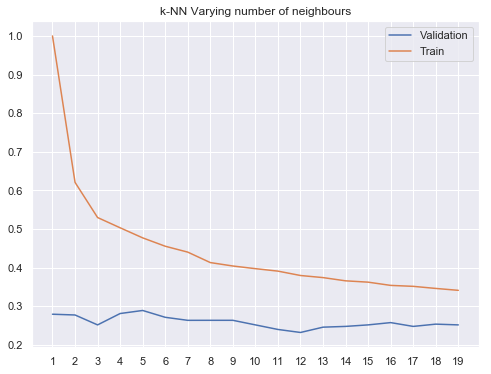

In [126]:
plt.title('k-NN Varying number of neighbours')
plt.plot(range(1,20),validation_scores,label="Validation")
plt.plot(range(1,20),train_scores,label="Train")
plt.legend()
plt.xticks(range(1,20))
plt.show()

c:\program files (x86)\python37-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


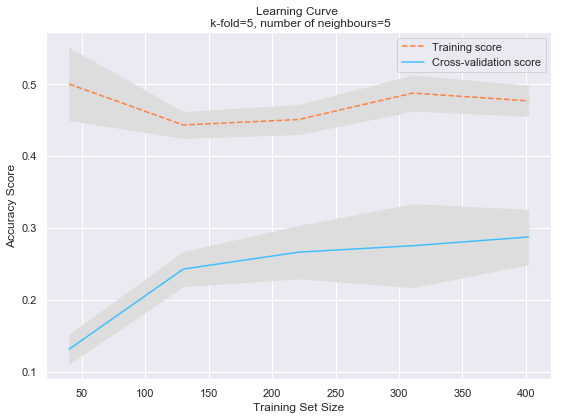

In [127]:
# Learning Curve

# How KNN algorithm performs in both small-size data and big-size data 

# choose an acceptable color
# https://www.spycolor.com/ff8040

from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(KNeighborsClassifier(5), 
        x_model, 
        y_model,
        # Number of folds in cross-validation
        cv=5,
        # Evaluation metric
        scoring='accuracy',
        # Use all computer cores
        n_jobs=-1, 
        # 50 different sizes of the training set
        train_sizes=np.linspace(0.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#ff8040",  label="Training score")
plt.plot(train_sizes, val_mean, color="#40bfff", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve \n k-fold=5, number of neighbours=5")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [128]:
# curse of dimensionality

# one or two features are simple, but it cannot recognize and divide our categories. more features means
# more evidence in different dimensions, but it could cause overfitting.

x = df[['team1', 'team2', 'toss_decision','toss_winner','city', 'venue', 'season', 'win_by_runs', 'win_by_wickets', 'umpire1']]
y = df[['winner']]

x_model, x_test, y_model, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_model, y_model, test_size=0.2, random_state=1)

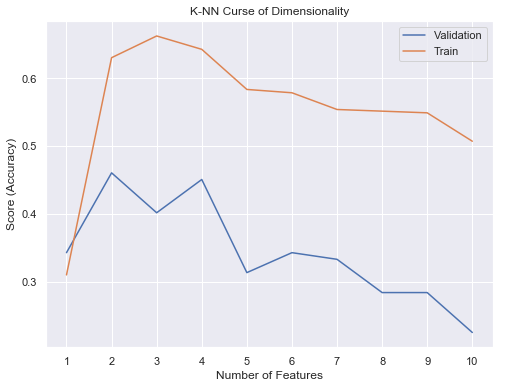

In [131]:
# [:, :2]extract columns

# convert[[1],[2],[3],...] to [1,2,3,4,0]
# x_train_values_list = np.array(x_train_values).tolist() 

'''
y_train_value = [j for i in y_train_values for j in i] - delete sublists to just one list

dimensionality = []
for i in range(10):

a = [item[:, :2] for item in list(x_train_values)]
print(a)
'''

d_train = []
d_val = []

x_train_values = x_train.values
y_train_values = y_train.values
x_val_values = x_val.values
y_val_values = y_val.values

for i in range(1,11):
    
    x_train_value = x_train_values[:,:i].tolist() #convert dataframe
    x_val_value = x_val_values[:,:i].tolist()
    
    knn = KNeighborsClassifier(5)
    Knn = knn.fit(x_train_value, y_train_values.ravel())

    d_train.append(Knn.score(x_train_value, y_train_values))
    d_val.append(Knn.score(x_val_value, y_val_values))

plt.title('K-NN Curse of Dimensionality')
plt.plot(range(1,11),d_val,label="Validation")
plt.plot(range(1,11),d_train,label="Train")
plt.xlabel('Number of Features')
plt.ylabel('Score (Accuracy)')
plt.legend()
plt.xticks(range(1,11))
plt.show()

In [88]:
# The best result is captured at k = 5 hence it is used for the final model.

#Setup a knn classifier with k neighbors

kfold = KFold(5, shuffle=True, random_state=42)
knn = KNeighborsClassifier(5)

for m,n in kfold.split(x_model_values):
        
        x_train_fold, y_train_fold = x_model_values[m], y_model_values[m]
        
        Knn = knn.fit(x_train_fold, y_train_fold.ravel())

print('When k=5, the testing score(accuracy) is: ')
print(Knn.score(x_test,y_test))

When k=5, the testing score(accuracy) is: 
0.2734375


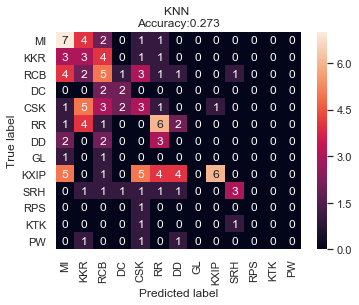

In [92]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

y_predict_knn = knn.predict(x_test)
cm = confusion_matrix(y_test, y_predict_knn) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW'], 
                     columns = ['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW' ])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('KNN \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_predict_knn)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [168]:
##Using SVM - Note that I have not fine tuned this method. This is just for practice purposes and ensuring I can correctly do the data science behind it.

In [166]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

classifier = SVC(gamma = 'auto')
svm_model = OneVsRestClassifier(classifier, n_jobs=1).fit(x_train, y_train)

print(svm_model.score(x_train,y_train))
print(svm_model.score(x_val,y_val))

1.0
0.14705882352941177


[0.0784313725490196, 0.18627450980392157, 0.28431372549019607, 0.2549019607843137, 0.06862745098039216, 0.049019607843137254, 0.0392156862745098, 0.029411764705882353, 0.06862745098039216]


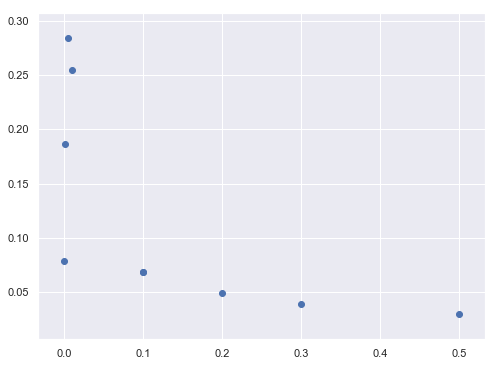

In [167]:

accuracy=[]
gamma=[0.0001, 0.001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.5, 0.1]

for a in gamma:
    classifier = SVC(C=1, 
        kernel='rbf', 
        degree=2, 
        gamma=a, 
        coef0=1,
        shrinking=True, 
        tol=0.5,
        probability=False, 
        cache_size=200, 
        class_weight=None,
        verbose=False, 
        max_iter=-1, 
        decision_function_shape=None, 
        random_state=None)
    svm_model = OneVsRestClassifier(classifier, n_jobs=1)
    svm_model.fit(x_train, y_train)
    predict=svm_model.predict(x_val)
    accuracy.append(svm_model.score(x_val,y_val))
print(accuracy)
plt.scatter(gamma, accuracy)

[0.0784313725490196, 0.16666666666666666, 0.22549019607843138, 0.18627450980392157, 0.24509803921568626, 0.2549019607843137, 0.27450980392156865, 0.24509803921568626, 0.2647058823529412, 0.27450980392156865, 0.20588235294117646, 0.2549019607843137, 0.24509803921568626, 0.2647058823529412, 0.27450980392156865, 0.28431372549019607, 0.29411764705882354]


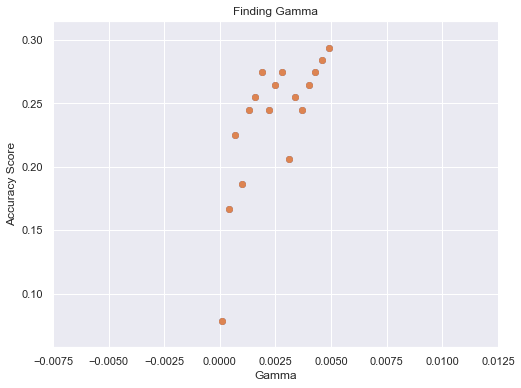

In [169]:
gamma=np.arange(0.0001, 0.005, 0.0003) 
accuracy=[]

for a in gamma:
    classifier = SVC(C=1, 
        kernel='rbf', 
        degree=2, 
        gamma=a, 
        coef0=1,
        shrinking=True, 
        tol=0.5,
        probability=False, 
        cache_size=200, 
        class_weight=None,
        verbose=False, 
        max_iter=-1, 
        decision_function_shape=None, 
        random_state=None)
    svm_model = OneVsRestClassifier(classifier, n_jobs=1)
    svm_model.fit(x_train, y_train)
    predict=svm_model.predict(x_val)
    accuracy.append(svm_model.score(x_val,y_val))
print(accuracy)
plt.scatter(gamma, accuracy)
plt.scatter(gamma, accuracy)
plt.title("Finding Gamma")
plt.xlabel("Gamma")
plt.ylabel("Accuracy Score")
plt.show()

[0.24509803921568626, 0.27450980392156865, 0.2549019607843137, 0.24509803921568626, 0.28431372549019607, 0.23529411764705882, 0.27450980392156865, 0.2647058823529412, 0.3137254901960784]


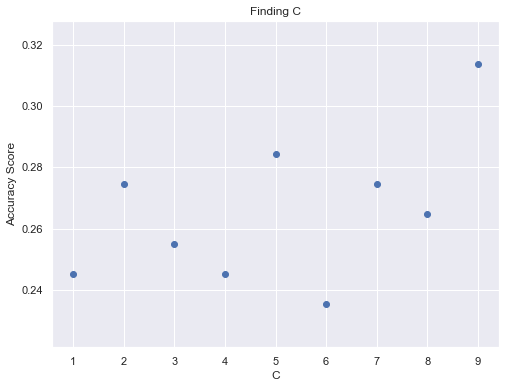

In [170]:
accuracy=[]
C=np.arange(1,10,1) 

for a in C:
    classifier = SVC(C=a, 
        kernel='rbf', 
        degree=2, 
        gamma=0.0013, 
        coef0=1,
        shrinking=True, 
        tol=0.5,
        probability=False, 
        cache_size=200, 
        class_weight=None,
        verbose=False, 
        max_iter=-1, 
        decision_function_shape=None, 
        random_state=None)
    svm_model = OneVsRestClassifier(classifier, n_jobs=1)
    svm_model.fit(x_train, y_train)
    predict=svm_model.predict(x_val)
    accuracy.append(svm_model.score(x_val,y_val))
print(accuracy)
plt.scatter(C, accuracy)
plt.title("Finding C")
plt.xlabel("C")
plt.ylabel("Accuracy Score")
plt.show()

In [171]:
classifier = SVC(C=9, # Regularization parameter
        kernel='rbf', # kernel type, rbf working fine here
        degree=2, # default value
        gamma=0.005, # kernel coefficient
        coef0=1, # change to 1 from default value of 0.0
        shrinking=True, # using shrinking heuristics
        tol=0.5, # stopping criterion tolerance 
        probability=False, # no need to enable probability estimates
        cache_size=200, # 200 MB cache size
        class_weight=None, # all classes are treated equally 
        verbose=False, # print the logs 
        max_iter=-1, # no limit, let it run
        decision_function_shape=None, # will use one vs rest explicitly 
        random_state=None)
svm_model = OneVsRestClassifier(classifier, n_jobs=1).fit(x_train, y_train)

print(svm_model.score(x_train,y_train))
print(svm_model.score(x_val,y_val))

0.9704433497536946
0.29411764705882354


c:\program files (x86)\python37-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


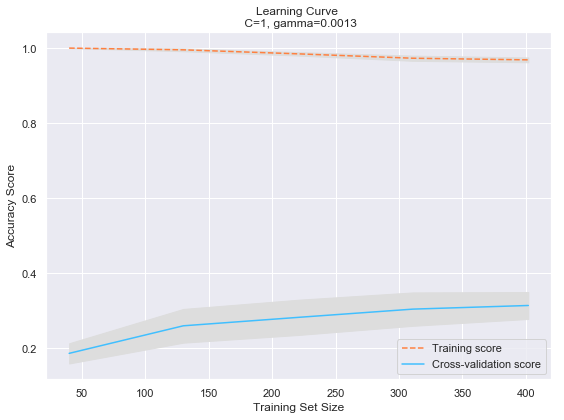

In [172]:
# Learning Curve

train_sizes, train_scores, val_scores = learning_curve(OneVsRestClassifier(classifier, n_jobs=1), 
        x_model, 
        y_model,
        # Number of folds in cross-validation
        cv=5,
        # Evaluation metric
        scoring='accuracy',
        # Use all computer cores
        # 50 different sizes of the training set
        train_sizes=np.linspace(0.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#ff8040",  label="Training score")
plt.plot(train_sizes, val_mean, color="#40bfff", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve \n C=1, gamma=0.0013")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [173]:
# curse of dimensionality

# one or two features are simple, but it cannot recognize and divide our categories. more features means
# more evidence in different dimensions, but it could cause overfitting.

# https://thispointer.com/select-rows-columns-by-name-or-index-in-dataframe-using-loc-iloc-python-pandas/

d_train = []
d_val = []

for i in range(1,11):
    
    x_train_index = x_train.iloc[: , 0:i]
    x_val_index = x_val.iloc[: , 0:i]
    
    classifier = SVC(C=9, # Regularization parameter
                    kernel='rbf', # kernel type, rbf working fine here
                    degree=2, # default value
                    gamma=0.005, # kernel coefficient
                    coef0=1, # change to 1 from default value of 0.0
                    shrinking=True, # using shrinking heuristics
                    tol=0.5, # stopping criterion tolerance 
                    probability=False, # no need to enable probability estimates
                    cache_size=200, # 200 MB cache size
                    class_weight=None, # all classes are treated equally 
                    verbose=False, # print the logs 
                    max_iter=-1, # no limit, let it run
                    decision_function_shape=None, # will use one vs rest explicitly 
                    random_state=None)
    svm_model = OneVsRestClassifier(classifier, n_jobs=1).fit(x_train_index, y_train)

    d_train.append(svm_model.score(x_train_index, y_train))
    d_val.append(svm_model.score(x_val_index, y_val))

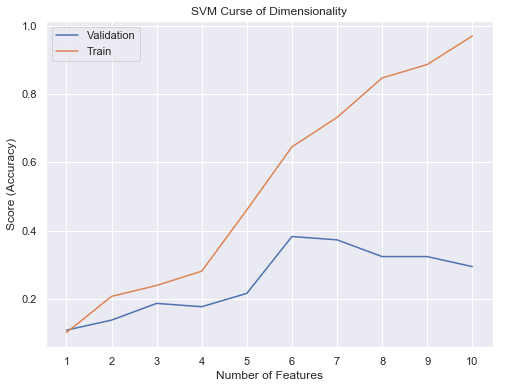

In [174]:
plt.title('SVM Curse of Dimensionality')
plt.plot(range(1,11),d_val,label="Validation")
plt.plot(range(1,11),d_train,label="Train")
plt.xlabel('Number of Features')
plt.ylabel('Score (Accuracy)')
plt.legend()
plt.xticks(range(1,11))
plt.show()

In [175]:
## Using Naive Bayes Theorem

In [176]:
# NB assumes that the features themselves are not correlated to each other. Therefore, if the collinearity of our features are low, the model will perform better.

x = df[['team1', 'team2', 'toss_decision','toss_winner','city', 'venue', 'season', 'win_by_runs', 'win_by_wickets', 'umpire1']]
y = df[['winner']]

x_model, x_test, y_model, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_model, y_model, test_size=0.2, random_state=1)

In [177]:
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB()
nb_model = gaussian.fit(x_train, y_train.values.ravel())

print(nb_model.score(x_train,y_train))

0.45566502463054187


In [178]:
train_score = []
val_score = []
a = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1]

#for i in np.arange(1,20):
for i in a:
    gaussian = GaussianNB(priors=None, var_smoothing=i)
    nb_model = gaussian.fit(x_train, y_train.values.ravel())
    train_score.append(nb_model.score(x_train, y_train))
    val_score.append(nb_model.score(x_val, y_val))

Text(0, 0.5, 'Accuracy')

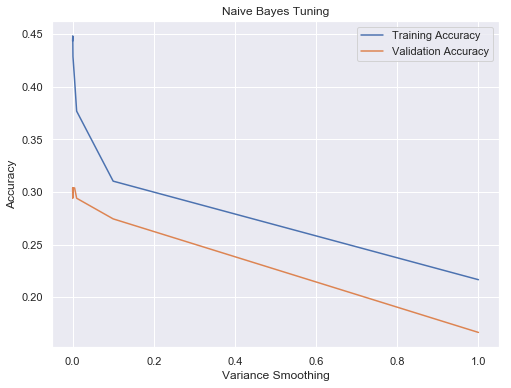

In [179]:
plt.plot(a,train_score)
plt.plot(a,val_score)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Naive Bayes Tuning')
plt.xlabel('Variance Smoothing')
plt.ylabel('Accuracy')

In [180]:
gaussian = GaussianNB(priors=None, var_smoothing=0.03)
nb_model = gaussian.fit(x_train, y_train.values.ravel())

print(nb_model.score(x_test, y_test))

0.2734375


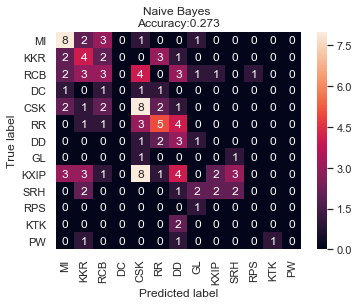

In [181]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

y_predict_nb = nb_model.predict(x_test)
cm = confusion_matrix(y_test, y_predict_nb) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW'], 
                     columns = ['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW' ])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Naive Bayes \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_predict_nb)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

c:\program files (x86)\python37-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


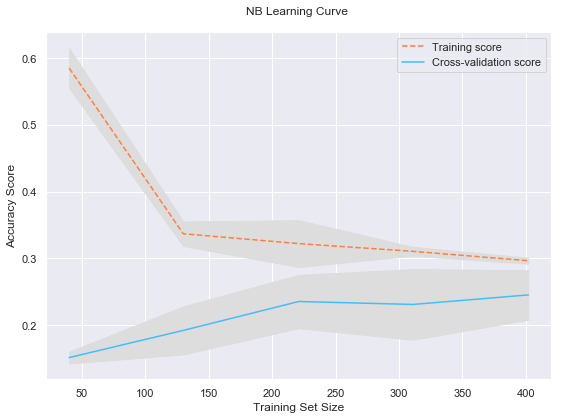

In [182]:
# Learning Curve

train_sizes, train_scores, val_scores = learning_curve(OneVsRestClassifier(GaussianNB(priors=None, var_smoothing=0.1)), 
        x_model, 
        y_model,
        # Number of folds in cross-validation
        cv=5,
        # Evaluation metric
        scoring='accuracy',
        # Use all computer cores
        # 50 different sizes of the training set
        train_sizes=np.linspace(0.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#ff8040",  label="Training score")
plt.plot(train_sizes, val_mean, color="#40bfff", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

# Create plot
plt.title("NB Learning Curve \n ")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

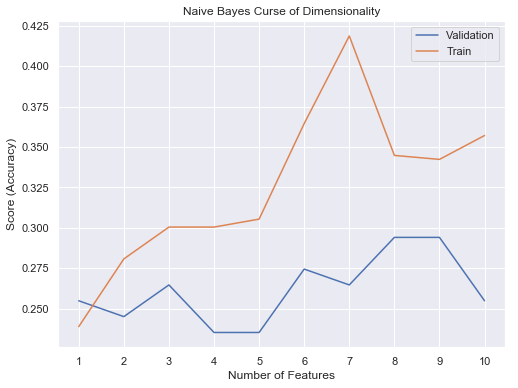

In [183]:
d_train = []
d_val = []

for i in range(1,11):
    
    x_train_index = x_train.iloc[: , 0:i]
    x_val_index = x_val.iloc[: , 0:i]
    
    classifier = GaussianNB(priors=None, var_smoothing=0.1)
    nb_model = gaussian.fit(x_train_index, y_train.values.ravel())

    d_train.append(nb_model.score(x_train_index, y_train))
    d_val.append(nb_model.score(x_val_index, y_val))
plt.title('Naive Bayes Curse of Dimensionality')
plt.plot(range(1,11),d_val,label="Validation")
plt.plot(range(1,11),d_train,label="Train")
plt.xlabel('Number of Features')
plt.ylabel('Score (Accuracy)')
plt.legend()
plt.xticks(range(1,11))
plt.show()

In [184]:
## Decision Tree Classifier

In [185]:

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(x_train, y_train)
print(decision_tree_model.score(x_train,y_train))
print(decision_tree_model.score(x_val,y_val))

1.0
0.5882352941176471


Text(0.5, 1.0, 'Figure 1.7 Importance of each Feature')

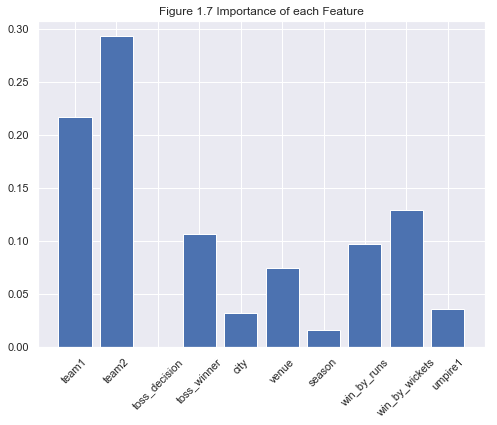

In [186]:
plt.bar(range(len(x_train.columns.values)), decision_tree_model.feature_importances_)
plt.xticks(range(len(x_train.columns.values)),x_train.columns.values, rotation= 45)
plt.title('Figure 1.7 Importance of each Feature')

Text(0, 0.5, 'Accuracy')

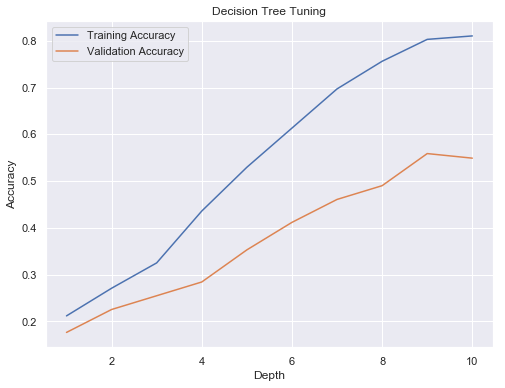

In [187]:
train_score = []
val_score = []
for depth in np.arange(1,11):
    decision_tree = tree.DecisionTreeClassifier(max_depth = depth,min_samples_leaf = 5)
    decision_tree.fit(x_train, y_train)
    train_score.append(decision_tree.score(x_train, y_train))
    val_score.append(decision_tree.score(x_val, y_val))

plt.plot(np.arange(1,11),train_score)
plt.plot(np.arange(1,11),val_score)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Decision Tree Tuning')
plt.xlabel('Depth')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

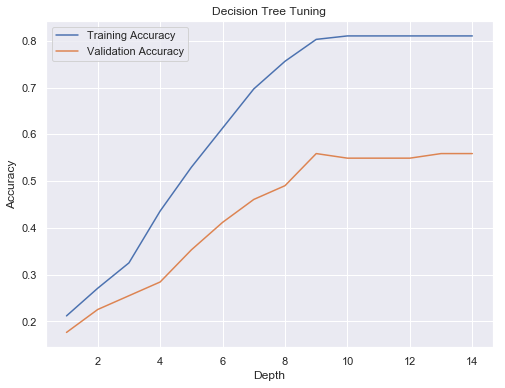

In [188]:
train_score = []
val_score = []
for depth in np.arange(1,15):
    decision_tree = tree.DecisionTreeClassifier(max_depth = depth,min_samples_leaf = 5)
    decision_tree.fit(x_train, y_train)
    train_score.append(decision_tree.score(x_train, y_train))
    val_score.append(decision_tree.score(x_val, y_val))

plt.plot(np.arange(1,15),train_score)
plt.plot(np.arange(1,15),val_score)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Decision Tree Tuning')
plt.xlabel('Depth')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

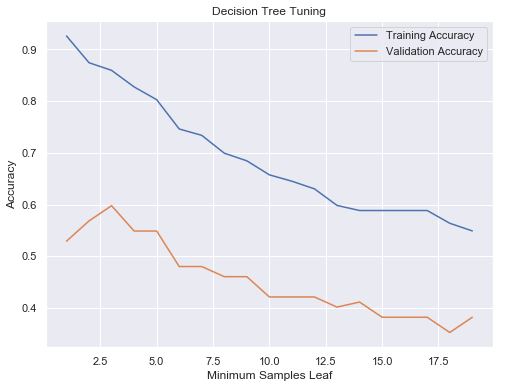

In [189]:
train_score = []
val_score = []
for leaf in np.arange(1,20):
    decision_tree = tree.DecisionTreeClassifier(max_depth = 9, min_samples_leaf = leaf)
    decision_tree.fit(x_train, y_train)
    train_score.append(decision_tree.score(x_train, y_train))
    val_score.append(decision_tree.score(x_val, y_val))

plt.plot(np.arange(1,20),train_score)
plt.plot(np.arange(1,20),val_score)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Decision Tree Tuning')
plt.xlabel('Minimum Samples Leaf')
plt.ylabel('Accuracy')

In [190]:
my_decision_tree_model = DecisionTreeClassifier(max_depth = 9, min_samples_leaf = 3)
my_decision_tree_model.fit(x_train, y_train)
print(my_decision_tree_model.score(x_train,y_train))
print(my_decision_tree_model.score(x_val,y_val))

0.8596059113300493
0.5882352941176471


In [191]:
print(my_decision_tree_model.score(x_test,y_test))

0.6484375


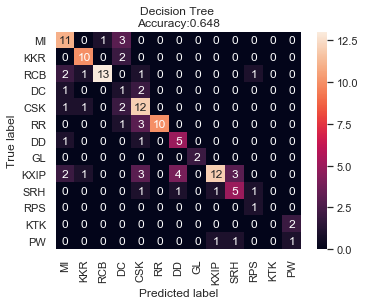

In [192]:
y_predict_decision = my_decision_tree_model.predict(x_test)
cm = confusion_matrix(y_test, y_predict_decision) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW'], 
                     columns = ['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW' ])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_predict_decision)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

c:\program files (x86)\python37-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


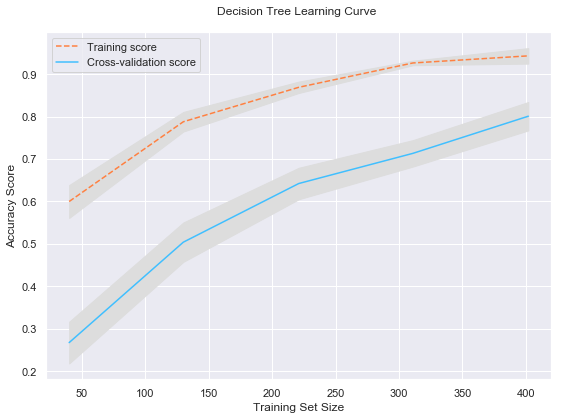

In [193]:
# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(OneVsRestClassifier(DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 6)), 
        x_model, 
        y_model,
        # Number of folds in cross-validation
        cv=5,
        # Evaluation metric
        scoring='accuracy',
        # Use all computer cores
        # 50 different sizes of the training set
        train_sizes=np.linspace(0.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#ff8040",  label="Training score")
plt.plot(train_sizes, val_mean, color="#40bfff", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

# Create plot
plt.title("Decision Tree Learning Curve \n ")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

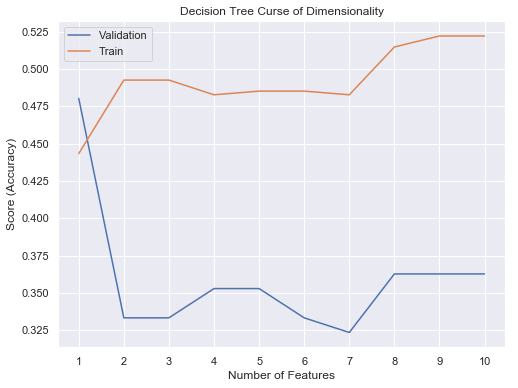

In [194]:
# Curse of Dimensionality

d_train = []
d_val = []

for i in range(1,11):
    
    x_train_index = x_train.iloc[: , 0:i]
    x_val_index = x_val.iloc[: , 0:i]
    
    classifier = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 6)
    dt_model = classifier.fit(x_train_index, y_train.values.ravel())

    d_train.append(dt_model.score(x_train_index, y_train))
    d_val.append(dt_model.score(x_val_index, y_val))
plt.title('Decision Tree Curse of Dimensionality')
plt.plot(range(1,11),d_val,label="Validation")
plt.plot(range(1,11),d_train,label="Train")
plt.xlabel('Number of Features')
plt.ylabel('Score (Accuracy)')
plt.legend()
plt.xticks(range(1,11))
plt.show()

In [195]:
## Using Logisitic Regression



In [196]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

logistic_model = LogisticRegression()
logistic_model.fit(x_train, y_train.values.ravel())

print(logistic_model.score(x_train,y_train))
print(logistic_model.score(x_val,y_val))

0.3669950738916256
0.3431372549019608


Text(0, 0.5, 'Accuracy')

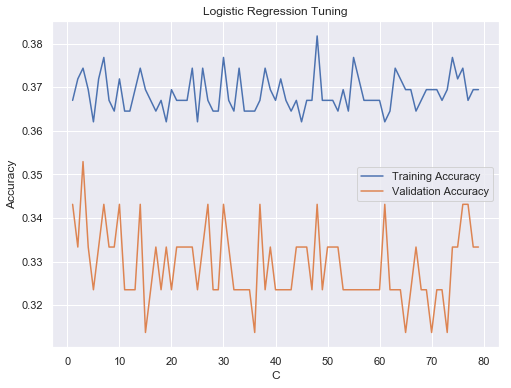

In [197]:
train_score = []
val_score=[]

for i in np.arange(1,80):
    
    logistic_model = LogisticRegression(penalty = 'l2', C = i,random_state = 0)
    
    logistic_model.fit(x_train,y_train.values.ravel()) 
    
    train_score.append(logistic_model.score(x_train, y_train))
    val_score.append(logistic_model.score(x_val,y_val))

    
plt.plot(np.arange(1,80),train_score)
plt.plot(np.arange(1,80),val_score)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Logistic Regression Tuning')
plt.xlabel('C')
plt.ylabel('Accuracy')

In [198]:
my_logistic_regression_model = LogisticRegression(penalty = 'l2', C = 48, random_state = 0)
my_logistic_regression_model.fit(x_train, y_train)
print(my_logistic_regression_model.score(x_train,y_train))
print(my_logistic_regression_model.score(x_val,y_val))

0.3817733990147783
0.3431372549019608


c:\program files (x86)\python37-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [199]:
print(my_logistic_regression_model.score(x_test,y_test))

0.3125


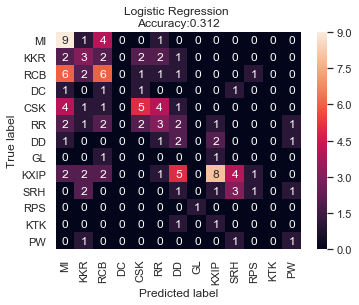

In [200]:
y_predict_logit = my_logistic_regression_model.predict(x_test)
cm = confusion_matrix(y_test, y_predict_logit) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW'], 
                     columns = ['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW' ])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_predict_logit)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

c:\program files (x86)\python37-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


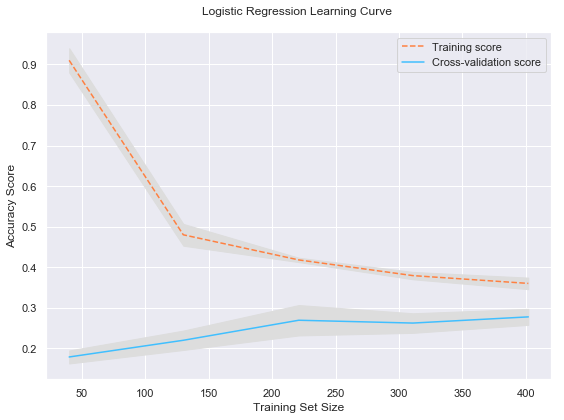

In [201]:
# Learning Curve

train_sizes, train_scores, val_scores = learning_curve(OneVsRestClassifier(LogisticRegression(penalty = 'l2', C = 48, random_state = 0)), 
        x_model, 
        y_model,
        # Number of folds in cross-validation
        cv=5,
        # Evaluation metric
        scoring='accuracy',
        # Use all computer cores
        # 50 different sizes of the training set
        train_sizes=np.linspace(0.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#ff8040",  label="Training score")
plt.plot(train_sizes, val_mean, color="#40bfff", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

# Create plot
plt.title("Logistic Regression Learning Curve \n ")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [203]:
# Curse of Dimensionality

d_train = []
d_val = []

for i in range(1,11):
    
    x_train_index = x_train.iloc[: , 0:i]
    x_val_index = x_val.iloc[: , 0:i]
    
    classifier = LogisticRegression(penalty = 'l2', C = 48, random_state = 0)
    lr_model = classifier.fit(x_train_index, y_train.values.ravel())

    d_train.append(lr_model.score(x_train_index, y_train))
    d_val.append(lr_model.score(x_val_index, y_val))

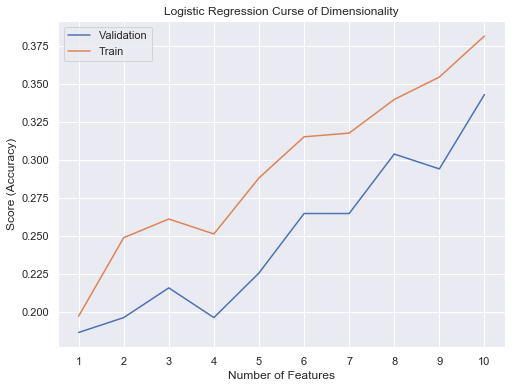

In [204]:
plt.title('Logistic Regression Curse of Dimensionality')
plt.plot(range(1,11),d_val,label="Validation")
plt.plot(range(1,11),d_train,label="Train")
plt.xlabel('Number of Features')
plt.ylabel('Score (Accuracy)')
plt.legend()
plt.xticks(range(1,11))
plt.show()

In [205]:
print("Logistic Regression \nAccuracy:{0:.4f}".format(accuracy_score(y_test, y_predict_logit)))
print("Decision Tree \nAccuracy:{0:.4f}".format(accuracy_score(y_test, y_predict_decision)))
print("Naive Bayes \nAccuracy:{0:.4f}".format(accuracy_score(y_test, y_predict_nb)))
print("KNN Accuracy \nAccuracy:{0:.4f}".format(accuracy_score(y_test, y_predict_knn)))
print("SVM Accuracy \nAccuracy:{0:.4f}".format(accuracy_score(y_test, y_predict_svm)))

Logistic Regression 
Accuracy:0.3125
Decision Tree 
Accuracy:0.6484
Naive Bayes 
Accuracy:0.2734
KNN Accuracy 
Accuracy:0.2734


==============================================================================================

Now we will be running the bowler's Regression to estimate the total number of runs conceded when they bowl in the IPL 

At this point, it is important to remember that we earlier grouped the deliveries data set that is viable for each and every bowler. Having named this as a data strucure, we save this file as a csv and now we call upon it seperately. As with the classification, I have omitted certain columns. You can do so otherwise or keep them at your discretion.

In [206]:
# Import the dataset
Bowlers = pandas.read_csv('Bowlers.csv')

In [208]:
# Make a copy
copy_data = Bowlers.copy()

In [209]:
#Ensure there are no missing values
null_values_col = copy_data.isnull().sum()
null_values_col = null_values_col[null_values_col != 0].sort_values(ascending = False).reset_index()
null_values_col.columns = ["variable", "number of missing"]
null_values_col.head()

,variable,number of missing


In [210]:
copy_data.head(3)

,over,wide_runs,noball_runs,runs,extras,wickets,Econ
0,4,3,1,55,4,1,13.75
1,3,0,0,36,0,0,12.00
2,3,0,0,41,0,0,13.67


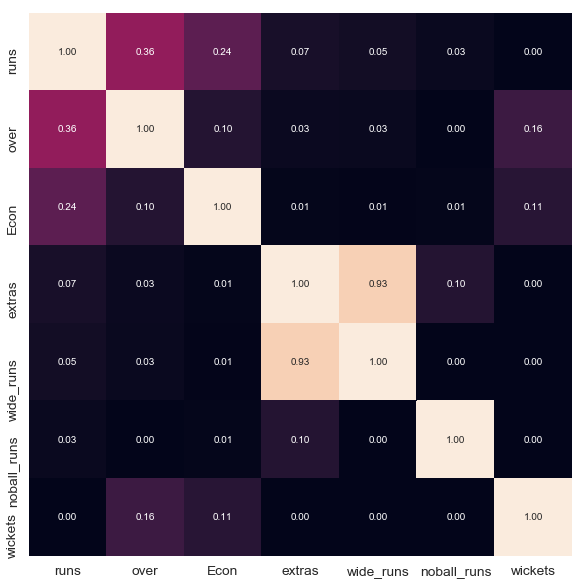

In [212]:
#This shows us the top correlated variables with respect to one another
df = DataFrame(copy_data,columns=['over', 'wide_runs', 'noball_runs', 'runs', 'extras', 'wickets', 'Econ'])

'''
pandas.DataFrame.corr
method : {‘pearson’, ‘kendall’, ‘spearman’}
pearson : standard correlation coefficient
kendall : Kendall Tau correlation coefficient
spearman : Spearman rank correlation

min_periods : int, optional
Minimum number of observations required per pair of columns to have a valid result. Currently only available for pearson and spearman correlation
'''

corrmat = df.corr(method='pearson', min_periods=1)
r_square = corrmat ** 2

## Top 8 correlated variables
k = 9 #number of variables for heatmap
cols = r_square.nlargest(k, 'runs')['runs'].index
cm = df[cols].corr()
cm_square = cm ** 2
f, ax = plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm_square, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [213]:
from sklearn.metrics import mean_squared_error

# RMSE for testing data

def rmse_model(model, x_test, y_test):
    predictions = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(predictions, y_test))
    return(rmse)

In [215]:
from sklearn.model_selection import train_test_split

x = df[['over', 'wide_runs', 'noball_runs','extras', 'wickets', 'Econ']]
y = df[['runs']]

x_model, x_test, y_model, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_model, y_model, test_size=0.2, random_state=1)

In [216]:
print("the number of data for training:")
print(y_train.count())
print("the number of data for validation:")
print(y_val.count())
print("the number of data for testing:")
print(y_test.count())

the number of data for training:
runs    4854
dtype: int64
the number of data for validation:
runs    1214
dtype: int64
the number of data for testing:
runs    1517
dtype: int64


In [217]:
#Basic Linear Regression
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(x_train, y_train)

print(rmse_model(linear_regression, x_test, y_test))
print(linear_regression.coef_)
print(linear_regression.intercept_)

3.692501179629424
[[ 8.63345885e+00 -8.68438655e+11 -8.68438655e+11  8.68438655e+11
  -6.91162109e-01  2.50439453e+00]]
[-22.66143661]


degree = 1, training RMSE = 3.64038, validation RMSE = 3.54619
degree = 2, training RMSE = 0.00354, validation RMSE = 0.00356
degree = 3, training RMSE = 0.00352, validation RMSE = 0.00360
degree = 4, training RMSE = 0.00349, validation RMSE = 0.00374
degree = 5, training RMSE = 0.00344, validation RMSE = 0.07533
degree = 6, training RMSE = 0.00338, validation RMSE = 2.20413
degree = 7, training RMSE = 0.00334, validation RMSE = 4.24160
degree = 8, training RMSE = 0.00330, validation RMSE = 1172.61926


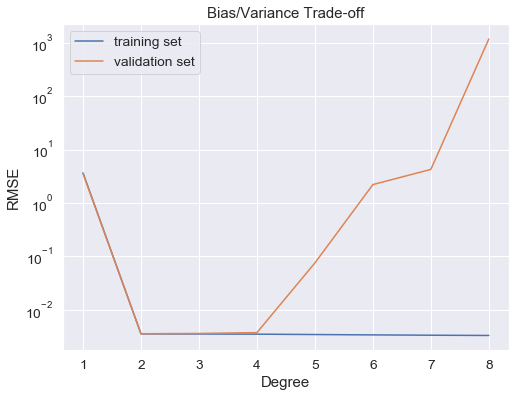

In [218]:
# Bias-Variance Trade-off

from sklearn.preprocessing import PolynomialFeatures

train_rmses = []
val_rmses = []
degrees = range(1,9)

for i in degrees:
    
    poly = PolynomialFeatures(degree=i, include_bias=False)
    x_train_poly = poly.fit_transform(x_train)

    poly_reg = LinearRegression()
    poly_reg.fit(x_train_poly, y_train)
    
    # training RMSE
    y_train_pred = poly_reg.predict(x_train_poly)
    train_poly_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    train_rmses.append(train_poly_rmse)
    
    # validation RMSE
    x_val_poly = poly.fit_transform(x_val)
    y_val_pred = poly_reg.predict(x_val_poly)
    
    val_poly_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_rmses.append(val_poly_rmse)

    print('degree = %s, training RMSE = %.5f, validation RMSE = %.5f' % (i, train_poly_rmse, val_poly_rmse))
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, train_rmses,label= 'training set')
ax.plot(degrees, val_rmses,label= 'validation set')
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')
ax.set_title('Bias/Variance Trade-off')  
plt.legend()
plt.show()

In [219]:
# RMSE for testing data

second_poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = second_poly.fit_transform(x_train)

second_reg = LinearRegression()
second_reg.fit(x_train_poly, y_train)

x_test_second_poly = second_poly.fit_transform(x_test)
y_test_pred = second_reg.predict(x_test_second_poly)

print(rmse_model(second_reg, x_test_second_poly, y_test))
print(second_reg.coef_)
print(second_reg.intercept_)

0.0035514307432025437
[[-6.59591630e-04  9.97144907e+07  9.97144907e+07 -9.97144907e+07
  -9.97446477e-06 -2.04821117e-05  1.30470842e-04 -4.65319338e+08
  -4.65319338e+08  4.65319338e+08 -9.46689397e-06  9.99998193e-01
   2.03348892e+08 -5.50389096e+08 -4.87451558e+08 -3.04405814e+08
   1.02189696e+08 -7.53737988e+08  4.69635322e+08 -3.04405814e+08
   1.02189696e+08  2.84102666e+08  3.04405814e+08 -1.02189696e+08
   4.84986231e-05 -1.42287463e-05  5.21540642e-07]]
[0.00077981]


In [220]:
# RMSE for testing data

second_poly = PolynomialFeatures(degree=1, include_bias=False)
x_train_poly = second_poly.fit_transform(x_train)

second_reg = LinearRegression()
second_reg.fit(x_train_poly, y_train)

x_test_second_poly = second_poly.fit_transform(x_test)
y_test_pred = second_reg.predict(x_test_second_poly)

print(rmse_model(second_reg, x_test_second_poly, y_test))
print(second_reg.coef_)
print(second_reg.intercept_)

3.6925289761772273
[[ 8.63373083e+00 -8.68750221e+11 -8.68750221e+11  8.68750221e+11
  -6.90673828e-01  2.50451660e+00]]
[-22.66349655]


In [221]:
#We now use Regularization to test co-efficent effectiveness

In [222]:
# At first, we calculate the RMSE before regularization.

poly = PolynomialFeatures(degree=6, include_bias=False)
x_train_poly = poly.fit_transform(x_train)

poly_reg = LinearRegression()
poly_reg.fit(x_train_poly, y_train)

x_test_poly = poly.fit_transform(x_test)
y_test_pred = poly_reg.predict(x_test_poly)

print(rmse_model(poly_reg, x_test_poly, y_test))

5.027401601327215


In [223]:
# RMSE for testing data

second_poly = PolynomialFeatures(degree=6, include_bias=False)
x_train_poly = second_poly.fit_transform(x_train)

second_reg = LinearRegression()
second_reg.fit(x_train_poly, y_train)

x_test_second_poly = second_poly.fit_transform(x_test)
y_test_pred = second_reg.predict(x_test_second_poly)

print(rmse_model(second_reg, x_test_second_poly, y_test))
print(second_reg.coef_)
print(second_reg.intercept_)

5.027401601327215
[[ 7.74182869e+03  1.17367350e-02 -2.78413896e-02 -1.61237872e-02
   1.99901171e-02  4.00722314e-01 -5.86482891e+02  6.26570792e-03
  -1.37078867e-02 -7.44272693e-03  1.99822007e-02  3.35425809e-01
   2.35691085e-03  9.78292082e-03  1.21398987e-02  6.78844092e-02
  -1.16047239e-02 -2.72395284e-02 -1.74565838e-02 -1.20483079e-01
   2.29133967e-02 -5.31675221e-03 -5.25986542e-02  1.13086710e-02
  -7.10756245e-02  1.24433494e-03  7.55891904e-06 -8.89447679e+02
  -2.43188991e-04  2.98214226e-03  2.73890696e-03  1.74602894e-02
   2.29323270e-01 -4.96682229e-03  7.86206757e-03  2.89524255e-03
   1.83077208e-03  1.19498030e-05 -1.20787420e-02 -4.21666936e-03
  -1.66859066e-03 -2.68711227e-04 -1.32142699e-03  1.62184662e-04
  -2.56764968e-04 -7.99416913e-02  4.75507922e-05 -2.79329468e-05
  -2.72321287e-03 -4.13841552e-04 -3.13705658e-03 -1.37344092e-02
   2.51968808e-03  9.62155095e-03  9.20770993e-03  5.37802541e-02
  -1.04657693e-02  6.07065109e-03  4.00458425e-02 -7.94608

In [224]:
#Ridge Regularization

c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.297903e-19
  overwrite_a=True).T
c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.070098e-19
  overwrite_a=True).T
c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.099199e-18
  overwrite_a=True).T
c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.1

[0.020322672540429118, 0.021506490528183528, 0.020377837909651624, 0.02858201415510584, 0.040774326913436874, 0.04681210464864605, 0.05014709927361221, 0.05207673491921888, 0.05391227798378737, 0.05392920883592895]


c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.003313e-17
  overwrite_a=True).T


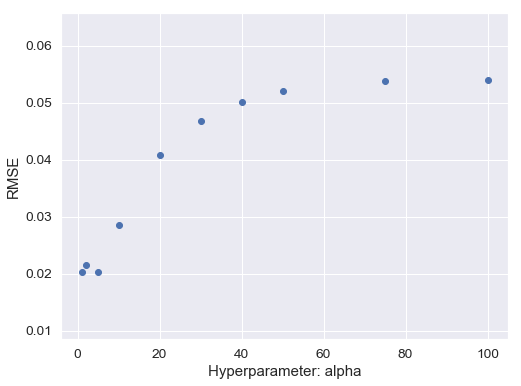

In [225]:
# Ridge

from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

rmse=[]
alpha=[1, 2, 5, 10, 20, 30, 40, 50, 75, 100]

for a in alpha:
    ridge = make_pipeline(PolynomialFeatures(6), Ridge(alpha=a))
    ridge.fit(x_train, y_train)
    predict=ridge.predict(x_val)
    rmse.append(np.sqrt(mean_squared_error(predict, y_val)))
print(rmse)
plt.ylabel('RMSE')
plt.xlabel('Hyperparameter: alpha')
plt.scatter(alpha, rmse)

[0.00467334824006714, 0.007046859844199995, 0.008786825377425015, 0.010221850770307189, 0.011514533051445505, 0.012734756363986384, 0.013914169916697852, 0.015067741507061012, 0.01620273511319963, 0.017322707542879952]


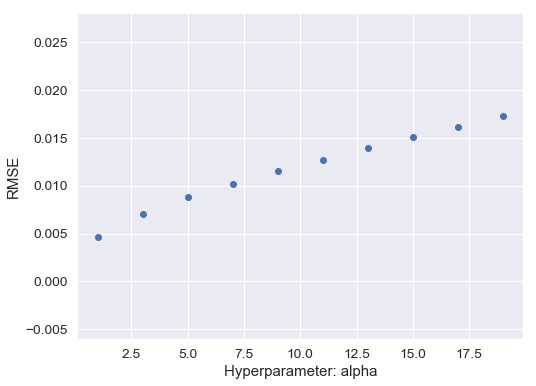

In [226]:
# Adjust alpha based on previous result

alpha=np.arange(1, 20, 2)
rmse=[]

for a in alpha:
    #ridge=Ridge(alpha=a, copy_X=True, fit_intercept=True)
    #ridge.fit(x_train, y_train)
    ridge = make_pipeline(PolynomialFeatures(4), Ridge(alpha=a))
    ridge.fit(x_train, y_train)
    predict=ridge.predict(x_val)
    rmse.append(np.sqrt(mean_squared_error(predict, y_val)))
print(rmse)
plt.ylabel('RMSE')
plt.xlabel('Hyperparameter: alpha')
plt.scatter(alpha, rmse)

c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.297903e-19
  overwrite_a=True).T
c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.337745e-19
  overwrite_a=True).T
c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.659302e-19
  overwrite_a=True).T
c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.2

[0.020322672540429118, 0.02101365489915998, 0.02142017765413227, 0.02160283110581801, 0.021613766052979964, 0.021506490528183528, 0.021323726973576818, 0.02110283673392756, 0.02087360946902063, 0.020645076523712624, 0.020436761020795963, 0.020255311486424017, 0.020108174351794298, 0.020000817645671916, 0.0199333811545777, 0.019909278285501097, 0.01992726078765247, 0.01998458935287818, 0.020081226875534864, 0.020212375478300307]


c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.264466e-18
  overwrite_a=True).T


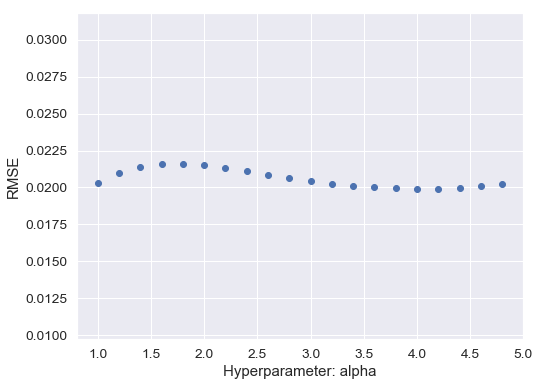

In [227]:
# Adjust alpha based on previous result

alpha=np.arange(1, 5, 0.2)
rmse=[]

for a in alpha:
    #ridge=Ridge(alpha=a, copy_X=True, fit_intercept=True)
    #ridge.fit(x_train, y_train)
    ridge = make_pipeline(PolynomialFeatures(6), Ridge(alpha=a))
    ridge.fit(x_train, y_train)
    predict=ridge.predict(x_val)
    rmse.append(np.sqrt(mean_squared_error(predict, y_val)))
print(rmse)
plt.ylabel('RMSE')
plt.xlabel('Hyperparameter: alpha')
plt.scatter(alpha, rmse)

In [228]:
# Use alpha=4.2 to predict the test data

ridge = make_pipeline(PolynomialFeatures(6), Ridge(alpha=4.2))
ridge_model = ridge.fit(x_train, y_train)

predictions = ridge_model.predict(x_test)
print("Ridge RMSE is: " + str(rmse_model(ridge_model, x_test, y_test)))

c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.744400e-18
  overwrite_a=True).T


Ridge RMSE is: 0.10353780073714876


c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[0.04360294009894403, 0.04081617161927535, 0.03489406959826632, 0.0853941867506027, 0.3527816419702061]


c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


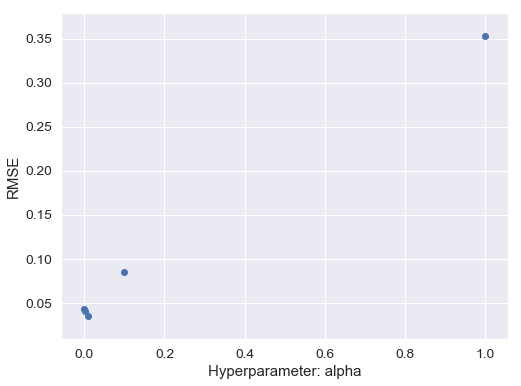

In [229]:
# Lasso

from sklearn.linear_model import Lasso

rmse=[]
alpha=[0.0001, 0.001, 0.01, 0.1, 1]

for a in alpha:
    lasso=make_pipeline(PolynomialFeatures(6), Lasso(alpha=a))
    lasso.fit(x_train, y_train)
    predict=lasso.predict(x_val)
    rmse.append(np.sqrt(mean_squared_error(predict, y_val)))
print(rmse)
plt.ylabel('RMSE')
plt.xlabel('Hyperparameter: alpha')
plt.scatter(alpha, rmse)

In [230]:
lasso = make_pipeline(PolynomialFeatures(6), Lasso(alpha=0.001))
lasso_model = lasso.fit(x_train, y_train)
predictions = lasso_model.predict(x_test)
print("RMSE in Testing : " + str(rmse_model(lasso_model, x_test, y_test)))

RMSE in Testing : 0.04556253787804011


In [231]:
# Comparison

print("For testing dataset\n")

print("Linear RMSE is: " + str(rmse_model(linear_regression, x_test, y_test)))
print("2nd Polynomial RMSE is: " + str(rmse_model(second_reg, x_test_second_poly, y_test)))

print("\nFor 6th order polynomial (RMSE = 5.027401601327215 before regualarization)")
print("Ridge RMSE is: " + str(rmse_model(ridge_model, x_test, y_test)))
print("Lasso RMSE is: " + str(rmse_model(lasso_model, x_test, y_test)))

For testing dataset

Linear RMSE is: 3.692501179629424
2nd Polynomial RMSE is: 5.027401601327215

For 6th order polynomial (RMSE = 5.027401601327215 before regualarization)
Ridge RMSE is: 0.10353780073714876
Lasso RMSE is: 0.04556253787804011


In [232]:
data = np.array([['','Parameter','RMSE'],
                ['1st-order Poly',1,3.6925289],
                ['2nd-order Poly',2,0.0035514],
                ['6th-order Poly',4,5.02740160],
                ['6th-order Lasso','<0.001',0.0455626],
                ['6th-order Ridge',4.2,0.1035378]])
                
regression_comparison = pd.DataFrame(data=data[1:,1:],
                                      index=data[1:,0],
                                    columns=data[0,1:])
regression_comparison

,Parameter,RMSE
1st-order Poly,1,3.6925289
2nd-order Poly,2,0.0035514
6th-order Poly,4,5.0274016
6th-order Lasso,<0.001,0.0455626
6th-order Ridge,4.2,0.1035378


In [233]:
my_ridge = Ridge(alpha = 4.2, normalize = True)
my_ridge.fit(x_train, y_train) 
#pd.Series(my_ridge.coef_,index = ['NBA_DraftNumber', 'Age', 'WS', 'BPM'])
my_ridge.coef_

array([[1.19244951, 0.2525031 , 0.79495296, 0.285872  , 0.0395364 ,
        0.33603287]])

In [234]:
my_lasso = Lasso(alpha = 0.001, normalize = True)
my_lasso.fit(x_train, y_train) 
my_lasso.coef_

array([ 8.52176098,  0.        ,  0.53551824,  0.22068013, -0.59004948,
        2.48183302])

In [235]:
data = np.array([['','over', 'wide_runs', 'noball_runs','extras', 'wickets', 'Econ'],
                ['Ridge',1.19244951, 0.2525031 , 0.79495296, 0.285872  , 0.0395364 , 0.33603287],
                ['Lasso',8.52176098,  0,  0.53551824,  0.22068013, -0.59004948,  2.48183302]])
                
regularization_comparison = pd.DataFrame(data=data[1:,1:],
                                      index=data[1:,0],
                                    columns=data[0,1:])
regularization_comparison

,over,wide_runs,noball_runs,extras,wickets,Econ
Ridge,1.19244951,0.2525031,0.79495296,0.285872,0.0395364,0.33603287
Lasso,8.52176098,0,0.53551824,0.22068013,-0.59004948,2.48183302


This is the end of the Project. Please message for any reccomendations or thoughts. I aim to update this within a year using new techniques as I learn. 
==================================================